## Minhash LSH Implementation

In [1]:
#pip install datasketch recordlinkage
#!pip install matplotlib

In [2]:
import numpy as np
import pandas as pd
import re
import time
import string
import random
from datasketch import MinHash, MinHashLSH
from recordlinkage.datasets import load_febrl1, load_febrl2, load_febrl3
import matplotlib

In [3]:
# df = load_febrl3()
# csv_file_path = 'febrl3_processed_with_text.csv'
# df.to_csv(csv_file_path, index=True, encoding='utf-8')

In [4]:
df = load_febrl3()
exclude_columns = ['soc_sec_id', 'street_number']
df_processed = df.fillna('')
cols_to_drop = [col for col in exclude_columns if col in df_processed.columns]
merged_column = df_processed.drop(columns=cols_to_drop).apply(lambda x: ' '.join(x.astype(str)), axis=1)
df["text"] = merged_column
csv_file_path = 'febrl3_processed_with_text.csv'
df.to_csv(csv_file_path, index=True, encoding='utf-8')

In [5]:
df.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,text
rec_id,,,,,,,,,,,
rec-1496-org,mitchell,green,7,wallaby place,delmar,cleveland,2119,sa,19560409,1804974,mitchell green wallaby place delmar cleveland ...
rec-552-dup-3,harley,mccarthy,177,pridhamstreet,milton,marsden,3165,nsw,19080419,6089216,harley mccarthy pridhamstreet milton marsden 3...
rec-988-dup-1,madeline,mason,54,hoseason street,lakefront retrmnt vlge,granville,4881,nsw,19081128,2185997,madeline mason hoseason street lakefront retrm...
rec-1716-dup-1,isabelle,NaN,23,gundulu place,currin ga,utakarra,2193,wa,19921119,4314184,isabelle gundulu place currin ga utakarra 219...
rec-1213-org,taylor,hathaway,7,yuranigh court,brentwood vlge,NaN,4220,nsw,19991207,9144092,taylor hathaway yuranigh court brentwood vlge ...


In [6]:
N_SHINGLE = 3
NUM_PERM = 256
def tokenize(text, n):
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = []
    for i in range(len(text) - n + 1):
        tokens.append(text[i:i+n])
    return tokens

def preprocess(text, n_shingle=N_SHINGLE):
    remove_chars = string.punctuation + '@.'
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', remove_chars))
    tokens = tokenize(text, n_shingle)
    return tokens

def get_minhash(text, num_perm=NUM_PERM, n_shingle=N_SHINGLE):
    tokens = preprocess(text, n_shingle)
    m = MinHash(num_perm=num_perm)
    for token in tokens:
        m.update(token.encode('utf8'))
    return m

In [7]:
INDEX_A = 1362
INDEX_B = 2245
text_A = df['text'].iloc[INDEX_A]
text_B = df['text'].iloc[INDEX_B]
shingles_A = set(preprocess(text_A))
shingles_B = set(preprocess(text_B))

print(f"Number of Shingles A({INDEX_A}): {len(shingles_A)}")
print(f"Number of Shingles B({INDEX_B}): {len(shingles_B)}")

Number of Shingles A(1362): 66
Number of Shingles B(2245): 67


In [8]:
intersection = len(shingles_A.intersection(shingles_B))
union = len(shingles_A.union(shingles_B))

J_actual = intersection / union
print(f"Actual Jaccard similarity: {J_actual:.4f}")

Actual Jaccard similarity: 0.7273


In [9]:
m_A = get_minhash(text_A)
m_B = get_minhash(text_B)
J_minhash_estimated = m_A.jaccard(m_B)
print(f"Estimated Jaccard similarity (MinHash): {J_minhash_estimated:.4f}")
print(f"\nDifference: {abs(J_minhash_estimated - J_actual):.4f}")

Estimated Jaccard similarity (MinHash): 0.7070

Difference: 0.0202


In [10]:
THRESHOLD = 0.45
start_time = time.time()
df['minhash_signature'] = df['text'].apply(lambda x: get_minhash(x, NUM_PERM, N_SHINGLE))
time_taken = time.time() - start_time
print(f"Completed creating MinHash signatures for {len(df)} records in {time_taken:.2f} seconds.")
print(f"Signature size: {len(df['minhash_signature'].iloc[0].hashvalues)}")

Completed creating MinHash signatures for 5000 records in 14.35 seconds.
Signature size: 256


In [11]:
df.head()

,given_name,surname,street_number,address_1,address_2,suburb,postcode,state,date_of_birth,soc_sec_id,text,minhash_signature
rec_id,,,,,,,,,,,,
rec-1496-org,mitchell,green,7,wallaby place,delmar,cleveland,2119,sa,19560409,1804974,mitchell green wallaby place delmar cleveland ...,<datasketch.minhash.MinHash object at 0x77fe9e...
rec-552-dup-3,harley,mccarthy,177,pridhamstreet,milton,marsden,3165,nsw,19080419,6089216,harley mccarthy pridhamstreet milton marsden 3...,<datasketch.minhash.MinHash object at 0x77fe9e...
rec-988-dup-1,madeline,mason,54,hoseason street,lakefront retrmnt vlge,granville,4881,nsw,19081128,2185997,madeline mason hoseason street lakefront retrm...,<datasketch.minhash.MinHash object at 0x77ff16...
rec-1716-dup-1,isabelle,NaN,23,gundulu place,currin ga,utakarra,2193,wa,19921119,4314184,isabelle gundulu place currin ga utakarra 219...,<datasketch.minhash.MinHash object at 0x77ff16...
rec-1213-org,taylor,hathaway,7,yuranigh court,brentwood vlge,NaN,4220,nsw,19991207,9144092,taylor hathaway yuranigh court brentwood vlge ...,<datasketch.minhash.MinHash object at 0x77ff16...


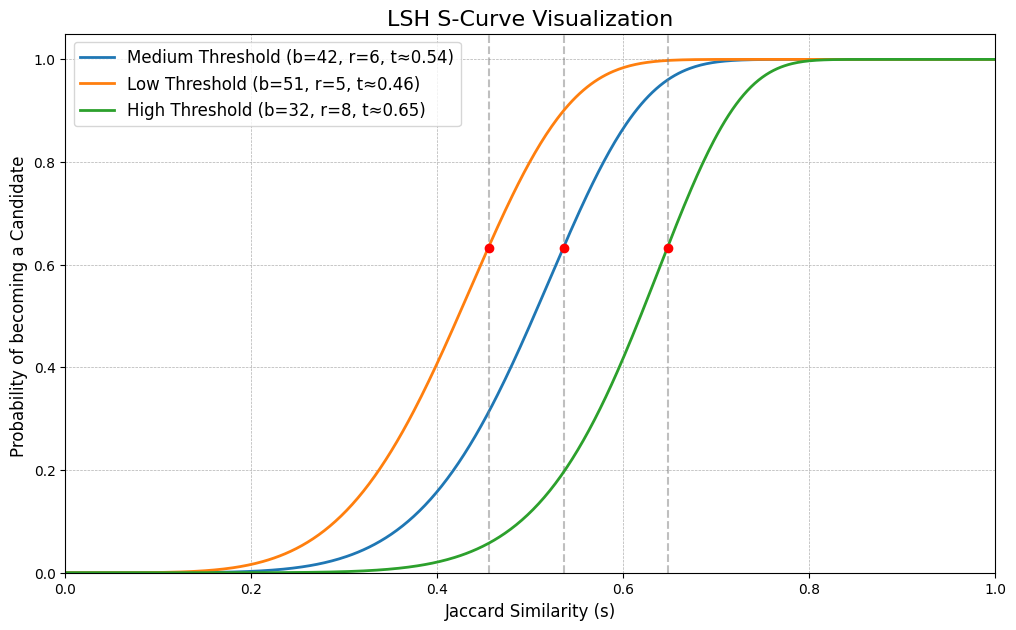

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lsh_curve(b, r, label=None):
    s = np.linspace(0, 1, 500)
    p = 1 - (1 - s**r)**b 
    
    t = (1/b)**(1/r)
    
    label_text = f"{label} (b={b}, r={r}, t≈{t:.2f})" if label else f"b={b}, r={r}"
    plt.plot(s, p, linewidth=2, label=label_text)
    
    plt.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
    plt.scatter([t], [1 - 1/np.e], color='red', zorder=5) 

plt.figure(figsize=(12, 7))

plot_lsh_curve(b=42, r=6, label="Medium Threshold")

plot_lsh_curve(b=51, r=5, label="Low Threshold")

plot_lsh_curve(b=32, r=8, label="High Threshold")

plt.title("LSH S-Curve Visualization", fontsize=16)
plt.xlabel("Jaccard Similarity (s)", fontsize=12)
plt.ylabel("Probability of becoming a Candidate ", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1.05)



plt.show()

In [13]:
lsh = MinHashLSH(threshold=THRESHOLD, num_perm=NUM_PERM)
start_time = time.time()
print(f"Starting MinHashLSH index construction with threshold {THRESHOLD}...")

for rec_id, m_sig in df['minhash_signature'].items():
    lsh.insert(rec_id, m_sig)

time_taken = time.time() - start_time
print(f'LSH Indexing completed in {time_taken:.4f} seconds.')
try:
    QUERY_ID = 'rec-10-org' 
    m_query = df.loc[QUERY_ID, 'minhash_signature']
    
    candidate_keys = lsh.query(m_query)
    
    print(f"LSH found {len(candidate_keys)} potential candidates.")

    if candidate_keys:
        for key in candidate_keys:
            record = df.loc[key] 
            jaccard_est = m_query.jaccard(record['minhash_signature'])
            print(f"Key (rec_id) {key} | Jaccard Est: {jaccard_est:.4f}")
            print(f"  > Name: {record['given_name']} {record['surname']}")
            
except KeyError:
    print("Could not find rec_id 'rec-0-org'. Please ensure index is correct.")

Starting MinHashLSH index construction with threshold 0.45...
LSH Indexing completed in 1.0164 seconds.
LSH found 4 potential candidates.
Key (rec_id) rec-10-dup-0 | Jaccard Est: 0.6875
  > Name: hannagan mikhayla
Key (rec_id) rec-10-org | Jaccard Est: 1.0000
  > Name: mikhayla hannagan
Key (rec_id) rec-10-dup-2 | Jaccard Est: 0.7031
  > Name: mikhayla hannaan
Key (rec_id) rec-10-dup-1 | Jaccard Est: 0.6094
  > Name: mikhvyla hannagan


In [14]:
def generate_ground_truth_from_ids(df):
    print("Generating Ground Truth from IDs...")
    start_time = time.time()
    
    entity_groups = {}
    
    for int_idx, rec_id_str in enumerate(df.index):
        try:
            parts = rec_id_str.split('-')
            entity_id = parts[1]
            
            if entity_id not in entity_groups:
                entity_groups[entity_id] = []
            entity_groups[entity_id].append(int_idx)
            
        except IndexError:
            continue 
            
    true_pairs = set()
    for ent_id, indices in entity_groups.items():
        if len(indices) > 1:
            for i in range(len(indices)):
                for j in range(i + 1, len(indices)):
                    pair = tuple(sorted((indices[i], indices[j])))
                    true_pairs.add(pair)
                    
    print(f"Done! Found {len(true_pairs)} actual duplicate pairs in {time.time() - start_time:.4f}s")
    return true_pairs

true_pairs_from_id = generate_ground_truth_from_ids(df)

def brute_force(df, threshold=THRESHOLD):
    start_time = time.time()
    shingle_sets = [set(preprocess(text, N_SHINGLE)) for text in df['text']]
    N = len(shingle_sets)
    candidate_pairs = set()
    
    print(f"\nStarting exact Jaccard brute-force comparison for {N} records...")
    
    for i in range(N):
        for j in range(i + 1, N):
            set_a = shingle_sets[i]
            set_b = shingle_sets[j]
            
            intersection = len(set_a.intersection(set_b))
            union = len(set_a.union(set_b))
            
            if union > 0:
                jaccard_actual = intersection / union
            else:
                jaccard_actual = 0.0
            
            if jaccard_actual >= threshold:
                candidate_pairs.add(tuple(sorted((i, j))))
                
    time_taken = time.time() - start_time
    print(f"Exact brute-force completed: {len(candidate_pairs)} pairs found in {time_taken:.4f} seconds.")
    return candidate_pairs, time_taken

def lsh_candidate_search(df, lsh_index):
    start_time = time.time()
    candidate_pairs = set()
    
    for key_idx, m_sig in df['minhash_signature'].items():
        candidates = lsh_index.query(m_sig)
        current_int_idx = df.index.get_loc(key_idx)
        
        for candidate_key in candidates:
            candidate_int_idx = df.index.get_loc(candidate_key)
            
            if key_idx != candidate_key: 
                candidate_pairs.add(tuple(sorted((current_int_idx, candidate_int_idx))))
                
    time_taken = time.time() - start_time
    return candidate_pairs, time_taken

true_pairs, true_time = brute_force(df, threshold=THRESHOLD)
lsh_pairs, lsh_time = lsh_candidate_search(df, lsh)

true_positives = len(lsh_pairs.intersection(true_pairs))

true_positives_real = len(lsh_pairs.intersection(true_pairs_from_id))

precision = true_positives_real / len(lsh_pairs) if len(lsh_pairs) > 0 else 0.0
recall = true_positives_real / len(true_pairs_from_id) if len(true_pairs) > 0 else 0.0

print("\nREALITY CHECK EVALUATION")
print(f"Total True Pairs (Exact Jaccard >= {THRESHOLD}): {len(true_pairs)}")
print(f"Total LSH Candidates Found: {len(lsh_pairs)}")
print(f"True Positives (Intersection): {true_positives}")
print(f"True Positives (Correctly identified by ID): {true_positives_real}")

print(f"\nPRECISION: {precision:.4f}")
print(f"RECALL: {recall:.4f}")

print("PERFORMANCE BENCHMARK")
print(f"Exact Brute-Force Time: {true_time:.4f} seconds")
print(f"LSH Search Time: {lsh_time:.4f} seconds")

if true_time > 0 and lsh_time > 0:
    print(f"LSH is {true_time / lsh_time:.1f} times faster than Exact Brute-Force.")

   



Generating Ground Truth from IDs...
Done! Found 6538 actual duplicate pairs in 0.0122s

Starting exact Jaccard brute-force comparison for 5000 records...
Exact brute-force completed: 6166 pairs found in 92.2666 seconds.

REALITY CHECK EVALUATION
Total True Pairs (Exact Jaccard >= 0.45): 6166
Total LSH Candidates Found: 6891
True Positives (Intersection): 5990
True Positives (Correctly identified by ID): 6113

PRECISION: 0.8871
RECALL: 0.9350
PERFORMANCE BENCHMARK
Exact Brute-Force Time: 92.2666 seconds
LSH Search Time: 0.7611 seconds
LSH is 121.2 times faster than Exact Brute-Force.


In [15]:
print(lsh.b, lsh.r)

47 5
